<a href="https://colab.research.google.com/github/tcarlon94/Relax_inc_study/blob/main/Relax_inc_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relax Inc. Challenge

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven day period , identify which factors predict future user
adoption.

## Import Modules

In [1]:
# Import key modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load & Explore Data

We have two csvs that we will later combine. The first, takehome_user_engagement has data around user logins. The second, takehome_users has features about the users. We'll load and explore the basics of these two data sources

In [2]:
# Load logins
logins = pd.read_csv('takehome_user_engagement.csv')
logins.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Looks like no null values for this sheet which is good. the time_stamp column isn't in datetime format so we'll have to change that.

In [4]:
logins.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


This won't give us much value as these columns are just ID's and 1 for visited.

In [5]:
# Load user data
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Here we have a lot fo null values in last session creation and invited by user_id columns

In [7]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


Most of our numeric columns are ids, dates, or boolean values so the numbers won't give much value.

# Data Cleaning/Imputing

We'll start with the logins dataframe. Since there are no missing values, we don't need to impute missing values.

Adopted users are defined as a user who has logged in 3 separate days in at least one 7 day period. Since same day logins do not matter for this, we'll check for duplicates first.

In [8]:
# Check for duplicates
logins.duplicated().sum()

np.int64(0)

Looks like there are no duplicates. Now we'll create a column to identify adopted users (boolean). First we have to update the time_stamp column to datetime

In [9]:
# Change dtype to datetime
logins['time_stamp'] = pd.to_datetime(logins['time_stamp'])
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


Now that it's in datetime, we can look at the logins in a 7 day period

In [10]:
# Sort by user_id & time_stamp to ensure they are sorted correctly
logins = logins.sort_values(by=['user_id', 'time_stamp'])
logins.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [11]:
# Create column for adopted user if 3 logins in 7 day period
logins['adopted_user'] = logins.groupby('user_id')['time_stamp'].diff().dt.days <= 7
logins.head()

,time_stamp,user_id,visited,adopted_user
0,2014-04-22 03:53:30,1,1,False
1,2013-11-15 03:45:04,2,1,False
2,2013-11-29 03:45:04,2,1,False
3,2013-12-09 03:45:04,2,1,False
4,2013-12-25 03:45:04,2,1,False


In [12]:
logins[logins['adopted_user'] == True].head(20)

,time_stamp,user_id,visited,adopted_user
5,2013-12-31 03:45:04,2,1,True
8,2014-02-08 03:45:04,2,1,True
9,2014-02-09 03:45:04,2,1,True
10,2014-02-13 03:45:04,2,1,True
11,2014-02-16 03:45:04,2,1,True
13,2014-03-13 03:45:04,2,1,True
21,2013-01-22 22:08:03,10,1,True
23,2013-02-04 22:08:03,10,1,True
24,2013-02-06 22:08:03,10,1,True
26,2013-02-17 22:08:03,10,1,True


We can see that user_id 2 is marked as False to start but is an adopted user. We'll impute the data to result in true if a user id has at least 1 True result

In [13]:
# Update adopted user column
logins['adopted_user'] = logins.groupby('user_id')['adopted_user'].transform(lambda x: x.any())
logins.head()

,time_stamp,user_id,visited,adopted_user
0,2014-04-22 03:53:30,1,1,False
1,2013-11-15 03:45:04,2,1,True
2,2013-11-29 03:45:04,2,1,True
3,2013-12-09 03:45:04,2,1,True
4,2013-12-25 03:45:04,2,1,True


We'll drop the time stamp and visited columns since we will only use user_id and adopted_user for our analysis

In [14]:
# Drop time stamp & visited
logins.drop(['time_stamp', 'visited'], axis=1, inplace=True)
logins.head()

,user_id,adopted_user
0,1,False
1,2,True
2,2,True
3,2,True
4,2,True


We'll drop duplicates for cleaner viewing

In [15]:
# Drope dupes
logins.drop_duplicates(inplace=True)
logins.head()

,user_id,adopted_user
0,1,False
1,2,True
15,3,False
16,4,False
17,5,False


Now that this is in a good setting, we can clean up the users df before joining them

We'll start with the columns with missing data. For invited by user_id we're going to change this to a boolean 0 for null values and 1 for values with user_id

In [16]:
# Impute invited by user id column
users['invited_by_user_id'] = users['invited_by_user_id'].apply(lambda x: 0 if np.isnan(x) else 1)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,1


Next, since last_session_creation_time is a unix timestamp, we can change this and creation date to datetime to maintain consistency

In [17]:
# Convert last session creation to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
users['creation_time'] = pd.to_datetime(users['creation_time'])
users.head(20)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,1
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,1


Since just knowing the last session time isn't entirely valuable, we'll create some new features based on this and creation date to provide more value.

We'll create variables for returning users (if they logged in at least one day after creation), Days from creation to last session, and if their last session falls within the last 30 days.

In [18]:
# Create returing users column
users['returning_user'] = users['last_session_creation_time'] > users['creation_time']
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,returning_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1,True
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1,True


In [19]:
# Create days from creation column
users['days_from_creation'] = (users['last_session_creation_time'] - users['creation_time']).dt.days
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,returning_user,days_from_creation
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1,False,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,True,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1,False,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1,True,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1,True,5.0


In [20]:
# Create session in last 30 days column
users['session_last_30_days'] = np.where(users['last_session_creation_time'] > users['last_session_creation_time']\
                                         .max() - pd.Timedelta(days=30),
                                         1,
                                         0)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,returning_user,days_from_creation,session_last_30_days
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1,False,0.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,True,136.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1,False,0.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1,True,1.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1,True,5.0,0


Now that we have columns that can better show impact on adoption, we can drop the last_session_creation column

In [21]:
# Drop last session creation
users.drop('last_session_creation_time', axis=1, inplace=True)
users.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,returning_user,days_from_creation,session_last_30_days
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,1,False,0.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,1,True,136.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1,False,0.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,1,True,1.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,1,True,5.0,0


Before combining the dataframes, we'll check for null and duplicate values

In [22]:
# Check for null
users.isnull().sum()

,0
object_id,0
creation_time,0
name,0
email,0
creation_source,0
opted_in_to_mailing_list,0
enabled_for_marketing_drip,0
org_id,0
invited_by_user_id,0
returning_user,0


Looks like there are a good portion of missing values from days from creation. Lets look at the values to see how to impute this

In [23]:
users['days_from_creation'].describe()

,days_from_creation
count,8823.000000
mean,59.222147
std,144.172167
min,0.000000
25%,0.000000
50%,1.000000
75%,20.000000
max,729.000000


It looks like some outliers are pulling the mean steeply. We'll impute the missing values iwth the median value of 1

In [24]:
# Impute missing with median
users['days_from_creation'].fillna(users['days_from_creation'].median(), inplace=True)
users.isnull().sum()

/tmp/ipython-input-523688613.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users['days_from_creation'].fillna(users['days_from_creation'].median(), inplace=True)


,0
object_id,0
creation_time,0
name,0
email,0
creation_source,0
opted_in_to_mailing_list,0
enabled_for_marketing_drip,0
org_id,0
invited_by_user_id,0
returning_user,0


Now there are no missing values. We'll check for duplicates

In [25]:
# Check for duplicates
users.duplicated().sum()

np.int64(0)

Now we'll join the dataframes.

In [26]:
# Join dfs
df = pd.merge(users, logins, left_on='object_id', right_on='user_id', how='left')
df.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,returning_user,days_from_creation,session_last_30_days,user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,1,False,0.0,0,1.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,1,True,136.0,0,2.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1,False,0.0,0,3.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,1,True,1.0,0,4.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,1,True,5.0,0,5.0,False


We'll drop the user_id column since it is redundant, change the boolean columsn to 0 or 1 values, and set the index to object_id to prep for analysis

In [27]:
# Drop user id
df.drop('user_id', axis=1, inplace=True)

In [28]:
# Change boolean columns to 0 or 1
df['adopted_user'] = df['adopted_user'].apply(lambda x: 1 if x == True else 0)
df['returning_user'] = df['returning_user'].apply(lambda x: 1 if x == True else 0)

In [29]:
# Set index to object id
df.set_index('object_id', inplace=True)
df.head()

,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,returning_user,days_from_creation,session_last_30_days,adopted_user
object_id,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,1,0,0.0,0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,1,1,136.0,0,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1,0,0.0,0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,1,1,1.0,0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,1,1,5.0,0,0


# EDA

Which factors predict future user adoption?

To start, we'll look at how our numeric columns correlate with user adoption

In [30]:
# Separate numeric columns
numeric_cols = df.select_dtypes(include=np.number)

In [31]:
# Correlation to adopted_user
numeric_cols.corr()['adopted_user']

,adopted_user
opted_in_to_mailing_list,0.015157
enabled_for_marketing_drip,0.013216
org_id,0.077639
invited_by_user_id,0.038445
returning_user,0.494284
days_from_creation,0.693143
session_last_30_days,0.584392
adopted_user,1.000000


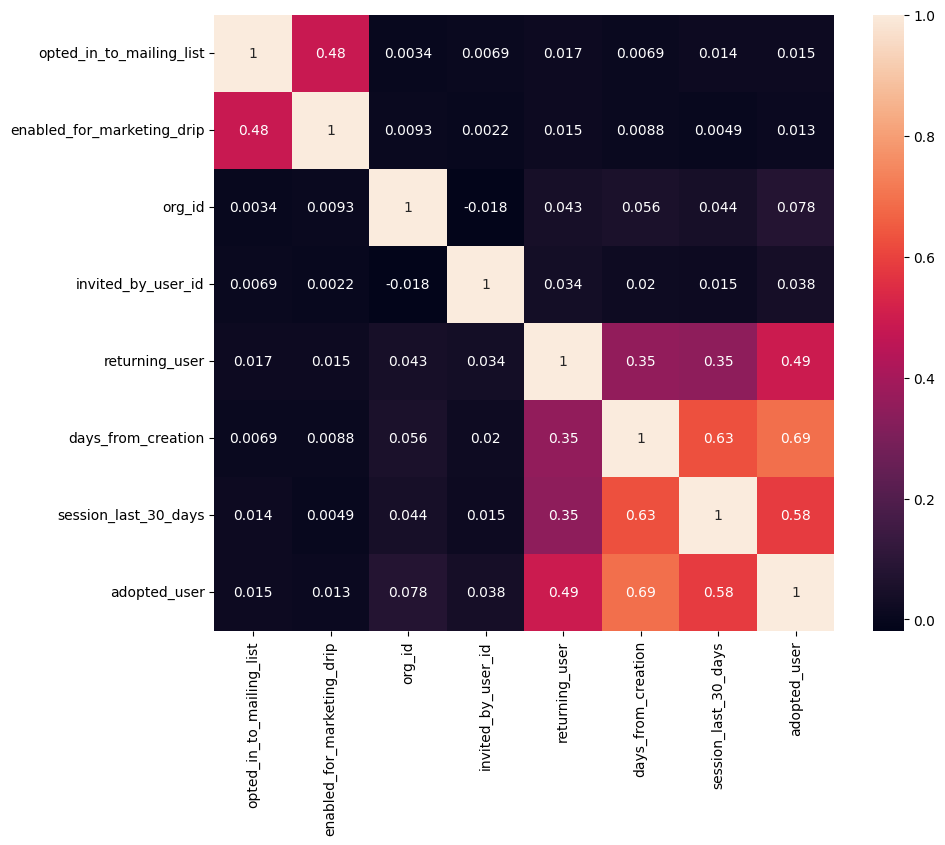

In [32]:
# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()

The columns with a strong postiive correlation to adopted users are sessions in the last 30 days, days from creation, and returning users. We'll visualize these correlations

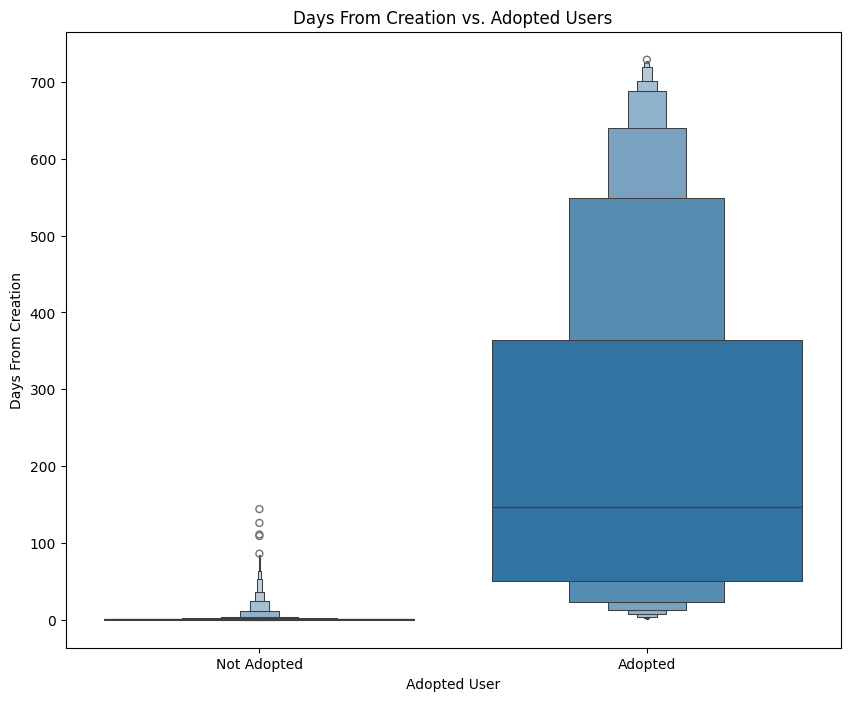

In [33]:
# Visualize adopted users & days from creation
plt.figure(figsize=(10, 8))
sns.boxenplot(x='adopted_user', y='days_from_creation', data=df)
plt.title('Days From Creation vs. Adopted Users')
plt.xlabel('Adopted User')
plt.xticks([0, 1], ['Not Adopted', 'Adopted'])
plt.ylabel('Days From Creation')
plt.show()

We can see here that users that are logging in months to years after signing up are much more likely to be adopted users. This is a key factor for user adoption

<Figure size 1000x800 with 0 Axes>

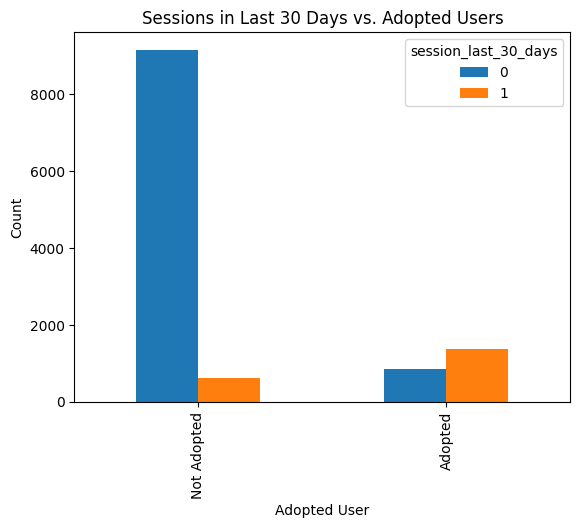

In [34]:
# Visualize Adopted users and sessions in last 30 days
conting_table = pd.crosstab(df['adopted_user'], df['session_last_30_days'])

plt.figure(figsize=(10, 8))
conting_table.plot(kind='bar')
plt.title('Sessions in Last 30 Days vs. Adopted Users')
plt.xlabel('Adopted User')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Adopted', 'Adopted'])
plt.show()

As we would expect, Adopted users are far more likely to have a session within the last 30 days. We'll do the same visualization for returning users

<Figure size 1000x800 with 0 Axes>

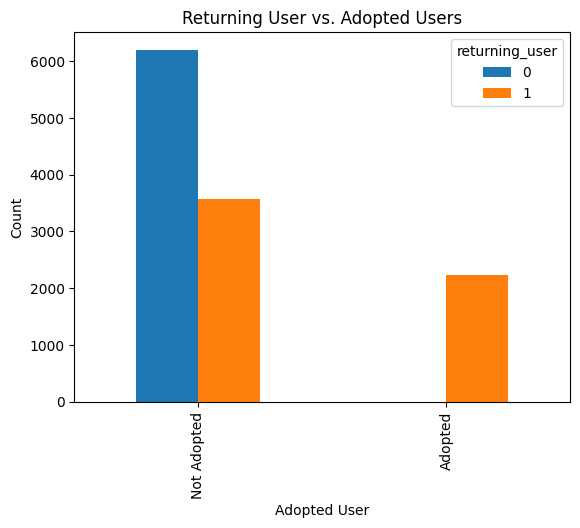

In [35]:
# Visualize Adopted users and returning user
conting_table_returning = pd.crosstab(df['adopted_user'], df['returning_user'])

plt.figure(figsize=(10, 8))
conting_table_returning.plot(kind='bar')
plt.title('Returning User vs. Adopted Users')
plt.xlabel('Adopted User')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Adopted', 'Adopted'])
plt.show()

This has some correlation but not as strong as days from creation and sessions in the last 30 days. Of course all adopted users are returning users based on our criteria. About a third of not adopted users are returning however so there is still a strong chance a returning user would be adopted.

Now that we've looked at correlation between numerical variables, we can look at categorical variables. We'll frist look at creation source, then creation time as the other categories are contact information.

<Figure size 1000x800 with 0 Axes>

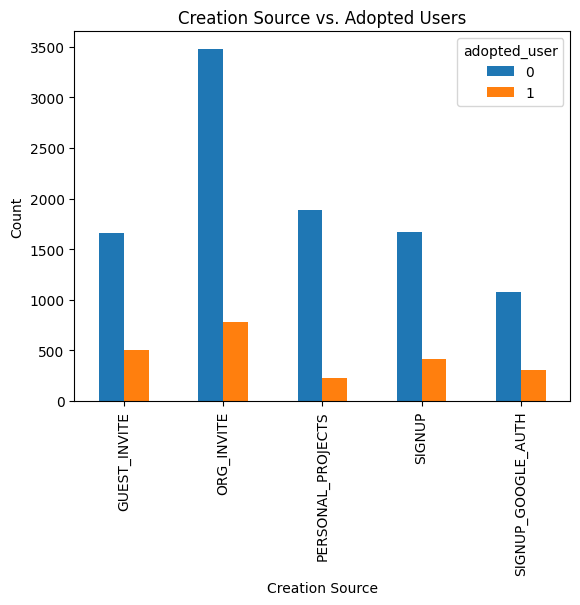

In [39]:
# Visualize Adopted users & creation source
conting_table_creation = pd.crosstab(df['creation_source'], df['adopted_user'])

plt.figure(figsize=(10, 8))
conting_table_creation.plot(kind='bar')
plt.title('Creation Source vs. Adopted Users')
plt.xlabel('Creation Source')
plt.ylabel('Count')
plt.show()

In [43]:
# Percentage of adopted users by creation source
conting_table_creation['Adopted Percentage'] = (conting_table_creation[1] / (conting_table_creation[0] + conting_table_creation[1])) * 100
conting_table_creation

adopted_user,0,1,Percentage,Adopted Percentage
creation_source,,,,
GUEST_INVITE,1659,504,23.300971,23.300971
ORG_INVITE,3476,778,18.288669,18.288669
PERSONAL_PROJECTS,1883,228,10.800568,10.800568
SIGNUP,1670,417,19.980834,19.980834
SIGNUP_GOOGLE_AUTH,1082,303,21.877256,21.877256


We can see there isn't a strong correlation for any of the creation sources. The highest percentage is guest invite and the lowest is personal projects. None of these have a strong enough correlation to be meaningful however

Last we'll analyze the creation date for adopted users. We'll go by month, year, and look at the trends over time

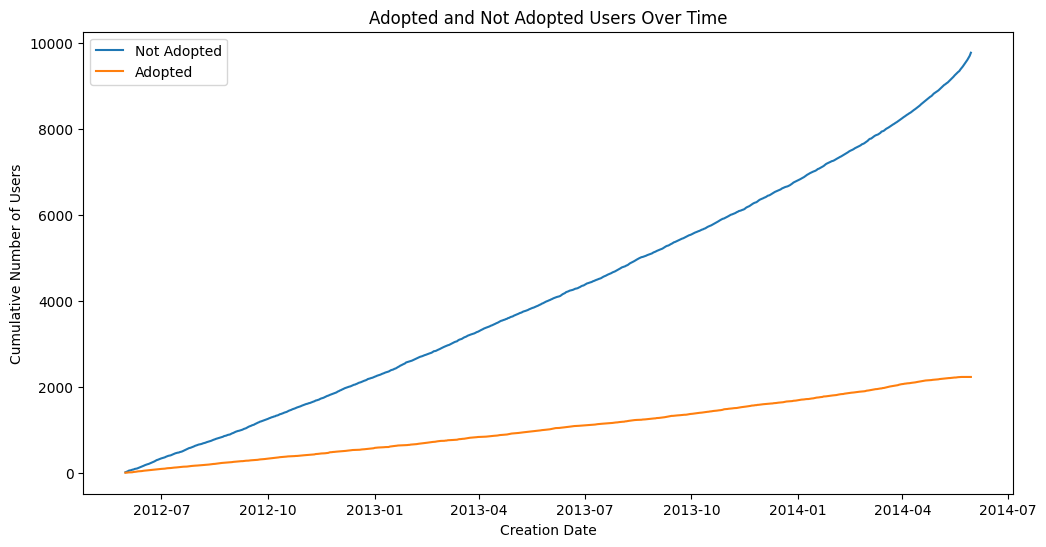

In [50]:
# Cumulative trend of adopted vs. not adopted
df_cumulative = df.groupby('creation_date')['adopted_user'].value_counts().unstack(fill_value=0)

df_cumulative['cumulative_not_adopted'] = df_cumulative[0].cumsum()
df_cumulative['cumulative_adopted'] = df_cumulative[1].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df_cumulative.index, df_cumulative['cumulative_not_adopted'], label='Not Adopted')
plt.plot(df_cumulative.index, df_cumulative['cumulative_adopted'], label='Adopted')
plt.title('Adopted and Not Adopted Users Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Cumulative Number of Users')
plt.legend()
plt.show()

This shows the trends stay pretty flat over tiem. We see a little uptick at the end for not adopted users but overall they both grow at a flat rate over time, indicating no strong correlation

<Figure size 1000x800 with 0 Axes>

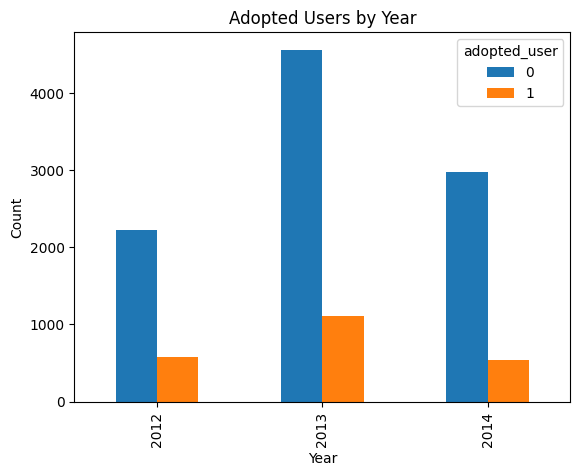

In [49]:
# Visualize adopted users by year
df['year'] = df['creation_time'].dt.year
conting_table_year = pd.crosstab(df['year'], df['adopted_user'])

plt.figure(figsize=(10, 8))
conting_table_year.plot(kind='bar')
plt.title('Adopted Users by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [51]:
# Percentages
conting_table_year['Adopted Percentage'] = (conting_table_year[1] / (conting_table_year[0] + conting_table_year[1])) * 100
conting_table_year

adopted_user,0,1,Adopted Percentage
year,,,
2012,2225,572,20.450483
2013,4563,1113,19.608879
2014,2982,545,15.452226


Again we see no strong correlation between adopted users and when they created an account. All years had 15-20% of users. The increase in signups in 2013 is mostly due to the fact that we have the full years worth of data as opposed to partial years for 2012 and 2014

<Figure size 1000x800 with 0 Axes>

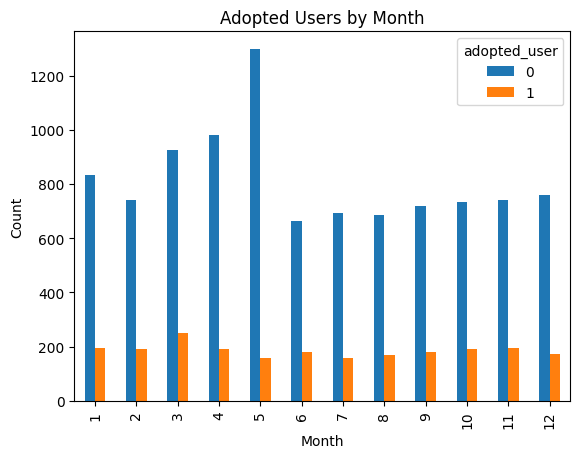

In [52]:
# Monthly adopted user
df['month'] = df['creation_time'].dt.month
conting_table_month = pd.crosstab(df['month'], df['adopted_user'])

plt.figure(figsize=(10, 8))
conting_table_month.plot(kind='bar')
plt.title('Adopted Users by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

In [53]:
# Percentages
conting_table_month['Adopted Percentage'] = (conting_table_month[1] / (conting_table_month[0] + conting_table_month[1])) * 100
conting_table_month

adopted_user,0,1,Adopted Percentage
month,,,
1,834,195,18.950437
2,741,193,20.663812
3,927,250,21.240442
4,979,190,16.253208
5,1298,157,10.790378
6,662,179,21.284185
7,694,158,18.544601
8,684,168,19.718310
9,720,181,20.088790


We still see no strong correlation here. Almost all months sit around 20% with May having the lowest at ~11%

# Conclusion

In conclusion, the factors that most strongly will predict user adoption are related to most recent logins. If they are still logging in months or years after their creation date they're more likely to be adopted users and if they're active recently they are more likely to be adopted. The goal should be to continue retaining the users and keep them returning the the platform.